This notebook investigates the possibility of doing hypothesis testing on a lognormal distribution.
Inverting a lognormal distribution is possible if the population variance is known, which is often unknown in practical statistical applications.
This notebook demonstrates high accuracy for using the sample variance as estimator of the population variance:
- accuracy averages above 95% across all sample sizes.
- accuracy stabilizes consistently above 95% as sample size exceeds 2000.
- bias reduction through bootstrapping seems effective in improving accuracy, however its beneficial effects decrease as sample size enlarges.

In [71]:
import numpy as np
import scipy.stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

In [72]:
def pull_observations_from_lognormal(sample_size: int):
    """
    Generates a sample from a standard lognormal distribution.

    Args:
        sample_size: The number of observations in the sample.

    Returns:
        A NumPy array containing the generated sample.
    """
    return rng.lognormal(mean=0.0, sigma=1.0, size=sample_size)


def calculate_confidence_interval(data: pd.Series, alpha: float):
    """
    Calculates the confidence interval for the mean of a sample.

    Args:
        data: A pandas Series containing the sample data.
        alpha: The significance level (e.g., 0.05 for a 95% confidence interval).

    Returns:
        A tuple containing the upper and lower bounds of the confidence interval.
    """
    sample_mean = data.mean()
    sample_std_dev = data.std()
    sample_size = len(data)
    std_error = sample_std_dev / np.sqrt(sample_size)

    upper_bound = scipy.stats.norm.ppf(1 - alpha, sample_mean, std_error)
    lower_bound = scipy.stats.norm.ppf(alpha, sample_mean, std_error)
    return upper_bound, lower_bound


def bootstrap_std_dev(series, n_bootstraps=10000):
    """
    Calculates the bootstrap estimate of the standard deviation of a sample.

    Args:
        series: The pandas Series containing the sample data.
        n_bootstraps: The number of bootstrap replicates to generate.
    
    Returns:
        The bootstrap estimate of the standard deviation.
    """
    series = pd.Series(series)
    bootstrap_std_devs = []
    for _ in range(n_bootstraps):
        bootstrap_sample = series.sample(n=len(series), replace=True)
        bootstrap_std_devs.append(bootstrap_sample.std())

    return np.mean(bootstrap_std_devs)


def invert_confidence_intervals(upper_bound: float, lower_bound: float, sample_std_dev: float, pop_std_dev: float):
    """
    Transforms confidence intervals from the log-space to the original space.

    Args:
        upper_bound: Upper bound of the confidence interval in log-space.
        lower_bound: Lower bound of the confidence interval in log-space.
        sample_std_dev: Sample standard deviation in log-space.
        pop_std_dev: Population standard deviation in log-space.

    Returns:
        Tuples containing the transformed upper and lower bounds 
        for the sample and population distributions.
    """
    sample_upper_bound = np.exp(upper_bound + sample_std_dev ** 2 / 2)
    sample_lower_bound = np.exp(lower_bound + sample_std_dev ** 2 / 2)

    pop_upper_bound = np.exp(upper_bound + pop_std_dev ** 2 / 2)
    pop_lower_bound = np.exp(lower_bound + pop_std_dev ** 2 / 2)

    return sample_upper_bound, sample_lower_bound, pop_upper_bound, pop_lower_bound


def test_confidence_interval(test_instances: int, sample_upper_bound, sample_lower_bound, pop_upper_bound, pop_lower_bound):
    """
    Tests if randomly generated observations fall within the specified confidence intervals of the population and sample.

    Args:
        test_instances: Number of test observations to generate.
        sample_upper_bound: Upper bound of the sample's confidence interval (CI).
        sample_lower_bound: Lower bound of the sample's confidence interval.
        pop_upper_bound: Upper bound of the population's confidence interval.
        pop_lower_bound: Lower bound of the population's confidence interval.

    Returns:
        A list of strings representing the classification of each test observation:
            'TP': True Positive (Test instance is inside both the populatin and the sample transformed CI)
            'FP': False Positive (Test instance is outside the population transformed CI, but inside the sample's)
            'TN': True Negative (Test instance is outside both the populatin and the sample transformed CI)
            'FN': False Negative (Test instance is inside the population transformed CI, but outside the sample's)
    """
    testing_instances = pull_observations_from_lognormal(sample_size=test_instances)

    sample_check = ''
    pop_check = ''
    result = []

    for sample in testing_instances:
        if sample_upper_bound > sample and sample_lower_bound < sample: 
            sample_check = 'inside'
        elif sample_lower_bound > sample: 
            sample_check = 'observation_below_lower'
        else: 'observation_above_upper'

        if pop_upper_bound > sample and pop_lower_bound < sample: 
            pop_check = 'inside'
        elif pop_lower_bound > sample: 
            pop_check = 'observation_below_lower'
        else: 'observation_above_upper'

        if sample_check == 'inside' and pop_check == 'inside':
            result.append('TP')
        elif sample_check == 'inside' and pop_check != 'inside':
            result.append('FP')
        elif sample_check != 'inside' and pop_check != 'inside':
            result.append('TN')
        elif sample_check != 'inside' and pop_check == 'inside':
            result.append('FN')

    return result


def calculate_confusion_matrix(list_of_results):
    """
    Calculates the confusion matrix from a list of classification results.

    Args:
        list_of_results: A list of strings representing the classification results.

    Returns:
        A tuple containing the number of True Positives (TP), False Positives (FP), 
        True Negatives (TN), and False Negatives (FN).
    """

    tp = sum(result == 'TP' for result in list_of_results)
    fp = sum(result == 'FP' for result in list_of_results)
    tn = sum(result == 'TN' for result in list_of_results)
    fn = sum(result == 'FN' for result in list_of_results)

    return tp, fp, tn, fn


def add_observation_to_df(df, sample_size, is_bootstrapped, tp, fp, tn, fn):
    """
    Adds a new row to a DataFrame with the specified results.

    Args:
        df: The existing DataFrame.
        sample_size: The sample size for the current iteration.
        is_bootstrapped: Boolean indicating whether bootstrapping was used.
        tp: Number of True Positives.
        fp: Number of False Positives.
        tn: Number of True Negatives.
        fn: Number of False Negatives.

    Returns:
        The updated DataFrame.
    """

    new_row = pd.DataFrame({
        'sample_size': [sample_size],
        'is_bootstrapped': [is_bootstrapped],
        'true_positives': [tp],
        'false_positives': [fp],
        'true_negatives': [tn],
        'false_negatives': [fn]
    })

    if df.empty:
        return new_row
    else:
        return pd.concat([df, new_row], ignore_index=True)


def iterate_testing(start_sample_size = 10, end_sample_size = 100000, increase_in_sample_size = 10, boostrap_sample_st_dev = False, bootstrap_iterations = 1000):
    """
    Iterates through different sample sizes, performs the confidence interval testing and stores its result.

    Args:
        start_sample_size: The starting sample size.
        end_sample_size: The ending sample size.
        increase_in_sample_size: The increment in sample size for each iteration.
        boostrap_sample_st_dev: Boolean indicating whether to use bootstrapped standard deviation.
        bootstrap_iterations: Number of bootstrap iterations if bootstrapping is used.

    Returns:
        A DataFrame containing the results for each sample size.
    """

    df = pd.DataFrame()
    for i in range(start_sample_size, end_sample_size, increase_in_sample_size):
        sample = pull_observations_from_lognormal(i)
        log_sample = np.log(sample)
        up, low = calculate_confidence_interval(log_sample, 0.05)

        if boostrap_sample_st_dev:
            st_dev_estimator = bootstrap_std_dev(log_sample, n_bootstraps=bootstrap_iterations)
        else:
            st_dev_estimator = log_sample.std()
        
        sample_upper_bound, sample_lower_bound, pop_upper_bound, pop_lower_bound = invert_confidence_intervals(up, low, st_dev_estimator, 1)
        
        test_result = test_confidence_interval(1000000, sample_upper_bound, sample_lower_bound, pop_upper_bound, pop_lower_bound)

        tp, fp, tn, fn = calculate_confusion_matrix(test_result)
        df = add_observation_to_df(df, i, boostrap_sample_st_dev, tp, fp, tn, fn)
        if i == end_sample_size / 2 or i == end_sample_size / 4 or i == end_sample_size * 3 / 4:
            print(f"The sample size was {i}, with bias correction boostrapping set to {boostrap_sample_st_dev}")
    return df

def iterate_testing_embbedded_ab_boostrapping(start_sample_size = 10, end_sample_size = 100000, increase_in_sample_size = 10, bootstrap_iterations = 2000):
    """
    Iterates through different sample sizes, performs the inversion of the confidence interval testing, with and without boostrapping for bias reduction, and stores its result.

    Args:
        start_sample_size: The starting sample size.
        end_sample_size: The ending sample size.
        increase_in_sample_size: The increment in sample size for each iteration.
        bootstrap_iterations: Number of bootstrap iterations.

    Returns:
        A DataFrame containing the results for each sample size.
    """

    df = pd.DataFrame()
    for i in range(start_sample_size, end_sample_size, increase_in_sample_size):
        sample = pull_observations_from_lognormal(i)
        log_sample = np.log(sample)
        up, low = calculate_confidence_interval(log_sample, 0.05)

        st_dev_estimator_b = bootstrap_std_dev(log_sample, n_bootstraps=bootstrap_iterations)
        st_dev_estimator = log_sample.std()
        
        sample_upper_bound, sample_lower_bound, pop_upper_bound, pop_lower_bound = invert_confidence_intervals(up, low, st_dev_estimator, 1)
        sample_upper_bound_b, sample_lower_bound_b, pop_upper_bound_b, pop_lower_bound_b = invert_confidence_intervals(up, low, st_dev_estimator_b, 1)
        
        test_result = test_confidence_interval(1000000, sample_upper_bound, sample_lower_bound, pop_upper_bound, pop_lower_bound)
        test_result_b = test_confidence_interval(1000000, sample_upper_bound_b, sample_lower_bound_b, pop_upper_bound_b, pop_lower_bound_b)

        tp, fp, tn, fn = calculate_confusion_matrix(test_result)
        tp_b, fp_b, tn_b, fn_b = calculate_confusion_matrix(test_result_b)
        df = add_observation_to_df(df, i, False, tp, fp, tn, fn)
        df = add_observation_to_df(df, i, True, tp_b, fp_b, tn_b, fn_b)
        if i == end_sample_size / 2 or i == end_sample_size / 4 or i == end_sample_size * 3 / 4:
            print(f"The sample size was {i}")
    return df 

In [73]:
non_boostrapped_df = iterate_testing(start_sample_size=10, end_sample_size=10000, increase_in_sample_size=10)
boostrapped_df = iterate_testing(start_sample_size=10, end_sample_size=10000, increase_in_sample_size=10, boostrap_sample_st_dev=True)

df = pd.concat([non_boostrapped_df, boostrapped_df], ignore_index=True)

df['accuracy'] = (df['true_positives'] + df['true_negatives']) / (df['true_positives'] + df['false_positives'] + df['true_negatives'] + df['false_negatives']) * 100
df['recall'] = (df['true_positives']) / (df['true_positives'] + df['false_negatives']) * 100
df['precision'] = (df['true_positives'] ) / (df['true_positives'] + df['false_positives']) * 100

df

The sample size was 2500, with bias correction boostrapping set to False
The sample size was 5000, with bias correction boostrapping set to False
The sample size was 7500, with bias correction boostrapping set to False
The sample size was 2500, with bias correction boostrapping set to True
The sample size was 5000, with bias correction boostrapping set to True
The sample size was 7500, with bias correction boostrapping set to True


,sample_size,is_bootstrapped,true_positives,false_positives,true_negatives,false_negatives,accuracy,recall,precision
0,10,False,452703,55378,467539,24380,92.0242,94.889778,89.100557
1,20,False,253757,5107,738891,2245,99.2648,99.123054,98.027149
2,30,False,97089,161558,631161,110192,72.8250,46.839315,37.537261
3,40,False,154384,63239,742977,39400,89.7361,79.668084,70.941031
4,50,False,190662,671,807566,1101,99.8228,99.425854,99.649303
...,...,...,...,...,...,...,...,...,...
1993,9950,True,16363,631,982383,623,99.8746,96.332274,96.286925
1994,9960,True,16386,262,983098,254,99.9484,98.473558,98.426237
1995,9970,True,14797,1456,982245,1502,99.7042,90.784711,91.041654
1996,9980,True,11990,4419,978932,4659,99.0922,72.016337,73.069657


<Axes: xlabel='sample_size', ylabel='accuracy'>

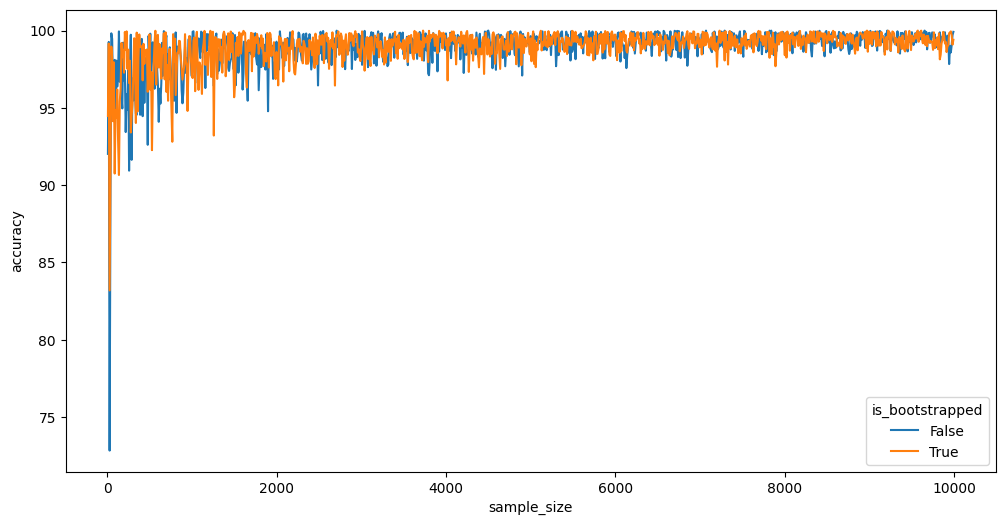

In [74]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='sample_size', y='accuracy', hue='is_bootstrapped')

<Axes: xlabel='sample_size', ylabel='precision'>

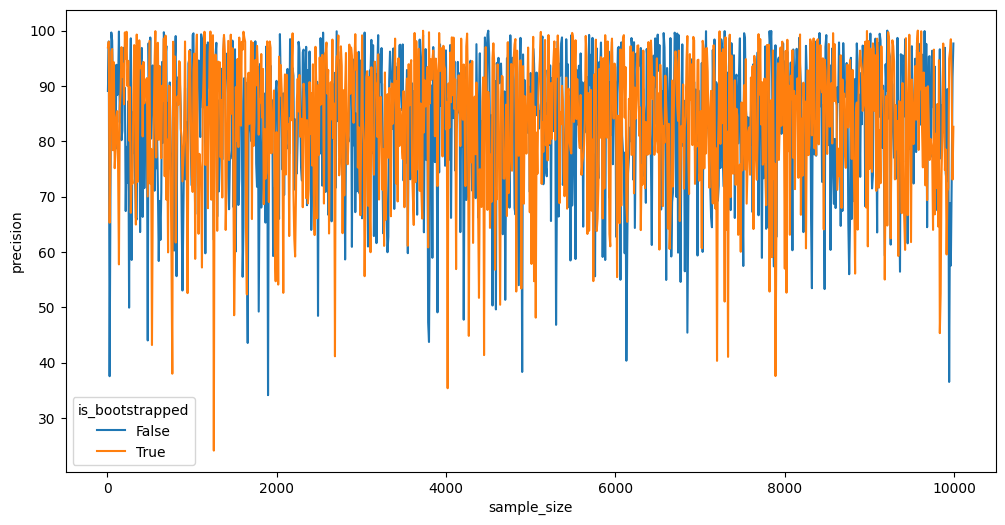

In [75]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='sample_size', y='precision', hue='is_bootstrapped')

<Axes: xlabel='sample_size', ylabel='recall'>

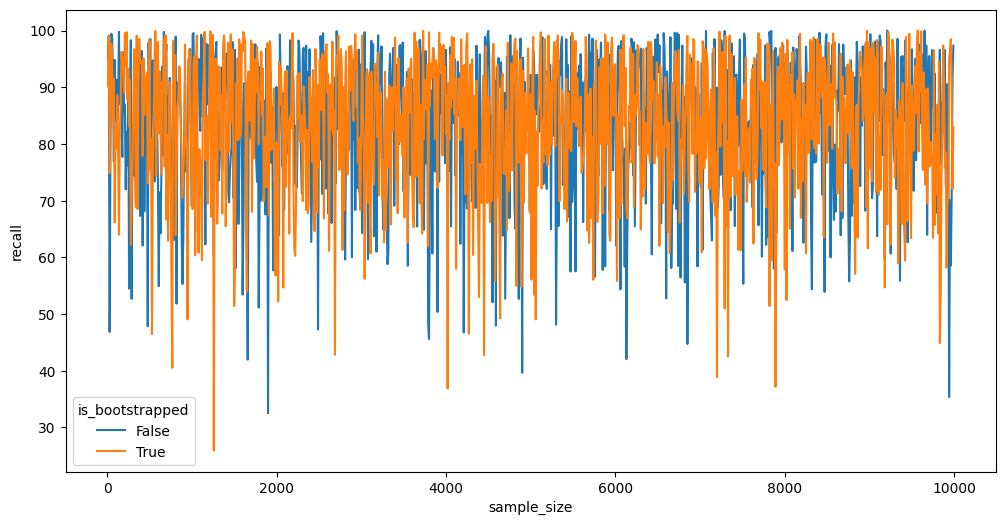

In [76]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='sample_size', y='recall', hue='is_bootstrapped')

In [77]:
df.groupby('is_bootstrapped').agg({'accuracy': 'mean', 'recall': 'mean', 'precision': 'mean'})



,accuracy,recall,precision
is_bootstrapped,,,
False,98.941504,83.309979,83.294247
True,98.964568,83.234207,83.192610


In [78]:
df.groupby('is_bootstrapped').agg({'accuracy': 'std', 'recall': 'std', 'precision': 'std'})

,accuracy,recall,precision
is_bootstrapped,,,
False,1.394733,12.512110,12.516960
True,1.213208,12.395304,12.481628


In [79]:
df[df['sample_size'] > 2000].groupby('is_bootstrapped').agg({'accuracy': 'mean', 'recall': 'mean', 'precision': 'mean'})

,accuracy,recall,precision
is_bootstrapped,,,
False,99.243643,83.532862,83.588126
True,99.224532,83.041280,83.020589


In [80]:
df[df['sample_size'] < 2000].groupby('is_bootstrapped').agg({'accuracy': 'mean', 'recall': 'mean', 'precision': 'mean'})

,accuracy,recall,precision
is_bootstrapped,,,
False,97.726681,82.381144,82.076021
True,97.922593,84.023973,83.891048


In [81]:
df[df['sample_size'] < 300].groupby('is_bootstrapped').agg({'accuracy': 'mean', 'recall': 'mean', 'precision': 'mean'})

,accuracy,recall,precision
is_bootstrapped,,,
False,95.474962,84.572238,83.668487
True,95.830455,86.195365,85.985660


In [82]:
df[df['sample_size'] < 100].groupby('is_bootstrapped').agg({'accuracy': 'mean', 'recall': 'mean', 'precision': 'mean'})

,accuracy,recall,precision
is_bootstrapped,,,
False,93.452511,86.910442,84.316397
True,94.162867,86.953871,86.450034


In [83]:
df[(df['sample_size'] >= 500) & (df['sample_size'] <= 1000)].groupby('is_bootstrapped').agg({'accuracy': 'mean', 'recall': 'mean', 'precision': 'mean'})

,accuracy,recall,precision
is_bootstrapped,,,
False,97.760673,81.458876,81.154641
True,97.795959,81.700739,81.672307


In [84]:
df[(df['sample_size'] >= 300) & (df['sample_size'] <= 500)].groupby('is_bootstrapped').agg({'accuracy': 'mean', 'recall': 'mean', 'precision': 'mean'})

,accuracy,recall,precision
is_bootstrapped,,,
False,96.963143,81.438067,80.654175
True,97.918567,87.458152,87.367290


In [85]:
ab_df = iterate_testing_embbedded_ab_boostrapping(start_sample_size=10, end_sample_size=10000, increase_in_sample_size=10)

The sample size was 2500
The sample size was 5000
The sample size was 7500


<Axes: xlabel='sample_size', ylabel='accuracy'>

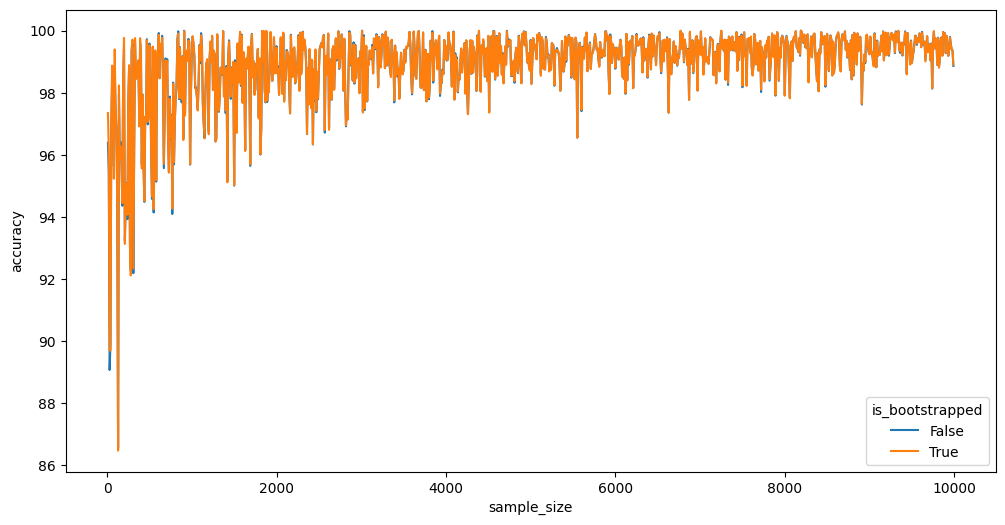

In [86]:
ab_df['accuracy'] = (ab_df['true_positives'] + ab_df['true_negatives']) / (ab_df['true_positives'] + ab_df['false_positives'] + ab_df['true_negatives'] + ab_df['false_negatives']) * 100
ab_df['recall'] = (ab_df['true_positives']) / (ab_df['true_positives'] + ab_df['false_negatives']) * 100
ab_df['precision'] = (ab_df['true_positives'] ) / (ab_df['true_positives'] + ab_df['false_positives']) * 100

plt.figure(figsize=(12, 6))
sns.lineplot(data=ab_df, x='sample_size', y='accuracy', hue='is_bootstrapped')

In [87]:
ab_df.groupby('is_bootstrapped').agg({'accuracy': 'mean', 'recall': 'mean', 'precision': 'mean'})

,accuracy,recall,precision
is_bootstrapped,,,
False,98.935032,82.854356,82.873577
True,98.939864,82.867223,82.894653


In [88]:
ab_df[(ab_df['sample_size'] >= 500) & (ab_df['sample_size'] <= 1000)].groupby('is_bootstrapped').agg({'accuracy': 'mean', 'recall': 'mean', 'precision': 'mean'})

,accuracy,recall,precision
is_bootstrapped,,,
False,97.988902,83.472735,83.889761
True,97.995516,83.502691,83.875547


In [89]:
ab_df[ab_df['sample_size'] <= 500].groupby('is_bootstrapped').agg({'accuracy': 'mean', 'recall': 'mean', 'precision': 'mean'})

,accuracy,recall,precision
is_bootstrapped,,,
False,96.384196,83.778609,84.127421
True,96.464708,84.032670,84.251700


In [90]:
ab_df[ab_df['sample_size'] <= 200].groupby('is_bootstrapped').agg({'accuracy': 'mean', 'recall': 'mean', 'precision': 'mean'})

,accuracy,recall,precision
is_bootstrapped,,,
False,95.570065,85.518449,86.913036
True,95.758250,86.123502,87.189091


In [91]:
ab_df[ab_df['sample_size'] >= 2000].groupby('is_bootstrapped').agg({'accuracy': 'mean', 'recall': 'mean', 'precision': 'mean'})

,accuracy,recall,precision
is_bootstrapped,,,
False,99.209998,82.833001,82.832573
True,99.209733,82.820931,82.842401


In [97]:
fdf = ab_df[ab_df['is_bootstrapped'] == False].merge(ab_df[ab_df['is_bootstrapped'] == True], how='inner', on=['sample_size'])
fdf['accuracy_diff'] = fdf['accuracy_x'] - fdf['accuracy_y']
fdf.sort_values('accuracy_diff', ascending=False)

,sample_size,is_bootstrapped_x,true_positives_x,false_positives_x,true_negatives_x,false_negatives_x,accuracy_x,recall_x,precision_x,is_bootstrapped_y,true_positives_y,false_positives_y,true_negatives_y,false_negatives_y,accuracy_y,recall_y,precision_y,accuracy_diff
11,120,False,112779,29447,835120,22654,94.7899,83.272910,79.295628,True,111447,31882,832418,24253,94.3865,82.127487,77.756072,0.4034
7,80,False,139167,25820,817127,17886,95.6294,88.611488,84.350282,True,137221,28090,815041,19648,95.2262,87.474899,83.007785,0.4032
3,40,False,156882,62037,742195,38886,89.9077,80.136692,71.662122,True,156644,63039,740291,40026,89.6935,79.648142,71.304562,0.2142
48,490,False,60463,14223,913186,12128,97.3649,83.292695,80.956270,True,59563,15143,912168,13126,97.1731,81.942247,79.729874,0.1918
27,280,False,57336,41972,865458,35234,92.2794,61.937993,57.735530,True,56272,43268,864833,35627,92.1105,61.232440,56.532047,0.1689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,70,False,144446,11829,824856,18869,96.9302,88.446254,92.430651,True,146891,10539,826187,16383,97.3078,89.965947,93.305596,-0.3776
8,90,False,189764,5122,798139,6975,98.7903,96.454694,97.371797,True,193085,2576,800844,3495,99.3929,98.222098,98.683437,-0.6026
2,30,False,264427,36478,626237,72858,89.0664,78.398684,87.877237,True,269575,34658,627388,68379,89.6963,79.766773,88.608073,-0.6299
1,20,False,301816,14089,652541,31554,95.4357,90.534841,95.540115,True,306820,11683,654830,26667,96.1650,92.003586,96.331903,-0.7293
